# Task 2: Lens Finding

### Submission By: [Saurabh Johri](mailto:saurabhxj@gmail.com)

### Task Description
Build a model classifying the images from \easy directory into lenses using PyTorch or Keras. Evaluate your algorithm on the images from \hard directory; note that only 20% of them have labels available, you can use the rest to train the domain adaptation model or other model of your choice. Pick the most appropriate approach and discuss your strategy.

### Dataset
A dataset comprising images with and without strong lenses. Images in three different filters are available for each object. Description of columns of files containing labels (easy_test.csv and hard_test_cut.csv) is in header.txt.

- There are 12000 images in the /easy directory with corresponding entries in the easy_test.csv as well as 2600 images in the /hard directory with correspondign entries in the hard_test_cut.csv
- The images have a dimension of (100 x 100) and have 3 separate single channel copies corresponding to different bands (red, infrared and green) in different folders.
- The images are in FITS (Flexible Image Transport System) file format.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%bash

tar -xzf /content/drive/MyDrive/DeepLenseGSOC/Task2/lens_finding.tgz --directory /content/

mkdir image_dataset
mkdir image_dataset/easy
mkdir image_dataset/hard
mkdir image_dataset/easy/0
mkdir image_dataset/easy/1
mkdir image_dataset/hard/0
mkdir image_dataset/hard/1

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#### Installing KerasCV

In [ ]:
%%bash
pip install -q --upgrade keras-cv tensorflow
pip install -q --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 956.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 4.1 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.


## Proposed Strategy

- Use KerasCV ImageClassifier with a pretrained model backbone to perform binary classification.
- Use a GPU to accelerate the training process (NVIDIA T4 in this case, through Google Colab)
- Load the images in *'.fits'* format using the astropy library and create a Tensorflow Dataset for model training using the keras utility for creating a dataset from directory.
- Combine the images corresponding to each of the three channels into a single 3-channel image for model training. The reasoning behind this decision is the model may be able to infer relationships between the different channels which might result in improved performance.
- Start without any data augmentation or any manipulations to establish a baseline and iterate with different techniques one-by-one if necessary.
- Use a training/validation split of 90% training to 10% validation.

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import numpy as np
import keras_cv

import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import roc_auc_score
import PIL
from PIL import Image
from glob import glob
from tqdm import tqdm
import gc
gc.enable()

%matplotlib inline

from astropy.io import fits

BATCH_SIZE = 32
RANDOM_SEED = 42

IMAGE_PATH = '/content/image_dataset'
PATH = '/content/lens_finding'

keras.utils.set_random_seed(RANDOM_SEED)

easydf = pd.read_csv('lens_finding/easy_test.csv')
harddf = pd.read_csv('lens_finding/hard_test_cut.csv')

### Image processing and Loading
- Read the image filenames from the pandas dataframes.
- Read and convert .fits images using astropy
- Normalize the image data using min max scaling.
- Stack the three channel arrays depth-wise to create a 3 channel images for training.
- Use PIL library to load the stacked array as an image and save it in a .png format.
- Save the newly created images into a folder structure that can be inferred by the keras utility to create a dataset from directory.

Min: 0.0
Max: 1.0
Mean: 0.29363468
Stdev: 0.11733242


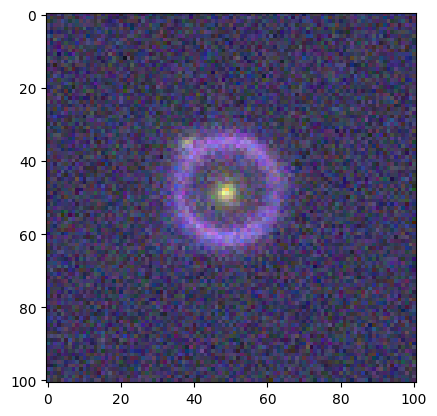

In [ ]:
def normalize(data, lower=0, upper=1):
    return ((data - data.min()) / (data.max() - data.min())) * (upper - lower) + lower

def load_fits(filename):
  hdu_list = fits.open(filename)
  arr = hdu_list[0].data
  hdu_list.close()
  return arr

image_data = {}
for i, band in enumerate(['R', 'I', 'G']):
  image_data[f'{band}'] = load_fits(f'{PATH}/easy/Band{i+1}/imageSDSS_{band}-100000.fits')

image_merge = np.dstack([normalize(image_data[f'R']), normalize(image_data[f'I']), normalize(image_data[f'G'])])

print('Min:', np.min(image_merge))
print('Max:', np.max(image_merge))
print('Mean:', np.mean(image_merge))
print('Stdev:', np.std(image_merge))

# Displaying Merged RGB image
plt.imshow(image_merge)

In [ ]:
for i, row in easydf.iterrows():
  id = row['ID']
  label = row['no_source']
  newimg_r = load_fits(f'{PATH}/easy/Band1/imageSDSS_R-{id}.fits')
  newimg_i = load_fits(f'{PATH}/easy/Band2/imageSDSS_I-{id}.fits')
  newimg_g = load_fits(f'{PATH}/easy/Band3/imageSDSS_G-{id}.fits')
  arr = np.dstack([normalize(newimg_r), normalize(newimg_i), normalize(newimg_g)])
  im = PIL.Image.fromarray((arr * 255).astype(np.uint8))
  im.save(f'{IMAGE_PATH}/easy/{label}/{id}.png')

for i, row in harddf.iterrows():
  id = row['ID']
  label = row['no_source']
  newimg_r = load_fits(f'{PATH}/hard/Band1/imageSDSS_R-{id}.fits')
  newimg_i = load_fits(f'{PATH}/hard/Band2/imageSDSS_I-{id}.fits')
  newimg_g = load_fits(f'{PATH}/hard/Band3/imageSDSS_G-{id}.fits')
  arr = np.dstack([normalize(newimg_r), normalize(newimg_i), normalize(newimg_g)])
  im = PIL.Image.fromarray((arr * 255).astype(np.uint8))
  im.save(f'{IMAGE_PATH}/hard/{label}/{id}.png')

### Create a tensorflow dataset
- Use the keras utility *image_dataset_from_directory* to create a dataset for binary classification.
- Use a training/validation split of 90%/10% from the /easy directory.
- Use the /hard directory images for the testing set.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
      f'{IMAGE_PATH}/easy',
      validation_split=0.1,
      subset="training",
      label_mode='binary',
      seed=RANDOM_SEED,
      batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
      f'{IMAGE_PATH}/easy',
      validation_split=0.1,
      subset="validation",
      label_mode='binary',
      seed=RANDOM_SEED,
      batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
      f'{IMAGE_PATH}/hard',
      label_mode='binary',
      seed=RANDOM_SEED,
      shuffle=False,
      batch_size=BATCH_SIZE)

Found 12000 files belonging to 2 classes.
Using 10800 files for training.
Found 12000 files belonging to 2 classes.
Using 1200 files for validation.
Found 2600 files belonging to 2 classes.


### Display some sample images
- The colors are not representative of the actual colors as the infrared channel is being treated as the blue channel while displaying.


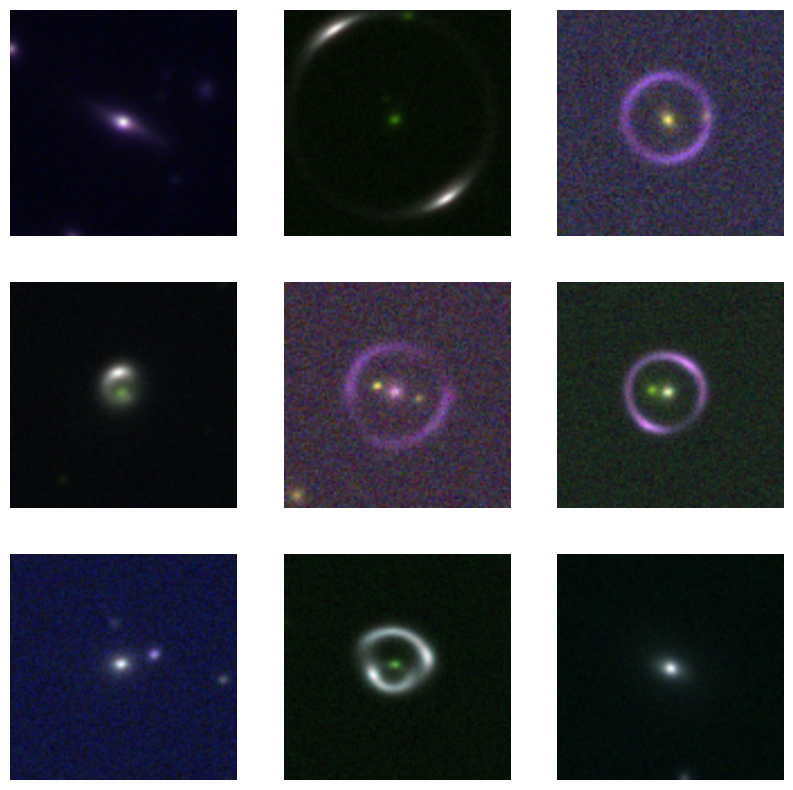

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

### Define model and training parameters

- Use the ImageClassifier from keras_cv that allows for pretrained model backbones to be used for classification.
- Use the EfficientNet backbone to establish a baseline.
- EfficientNet achieves better or similar accuracy with fewer iterations when compared to its counterparts trained on the imagenet dataset.
- Use early stopping to halt training once validation loss stops improving.
- Save best model weights using the ModelCheckpoint callback.
- The garbage collection callback is used to minimize any issues with memory leaks during training.
- Measure accuracy and AUC score metrics during training.

In [ ]:
# using the efficient net backbone
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
    "efficientnetv2_b0_imagenet"
)

# configuring image classifier for binary classification
model = keras_cv.models.ImageClassifier(
    backbone=backbone,
    num_classes=1,
    activation="sigmoid",
)

EPOCHS = 25

model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),
    metrics=['accuracy', 'auc']
)

class GarbageCollectionCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

es = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        verbose=1,
        restore_best_weights=True)

checkpoint_path = f'/content/drive/MyDrive/DeepLenseGSOC/Task2/task_2.weights.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss',
                                                 mode='min')

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[GarbageCollectionCallback(), cp_callback, es]
)

Epoch 1/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 259s 398ms/step - accuracy: 0.7000 - auc: 0.7662 - loss: 0.6279 - val_accuracy: 0.9100 - val_auc: 0.9769 - val_loss: 0.3448
Epoch 2/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 54s 158ms/step - accuracy: 0.9007 - auc: 0.9690 - loss: 0.3306 - val_accuracy: 0.9458 - val_auc: 0.9914 - val_loss: 0.1601
Epoch 3/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 82s 159ms/step - accuracy: 0.9265 - auc: 0.9818 - loss: 0.2028 - val_accuracy: 0.9583 - val_auc: 0.9949 - val_loss: 0.1081
Epoch 4/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 55s 161ms/step - accuracy: 0.9419 - auc: 0.9884 - loss: 0.1525 - val_accuracy: 0.9617 - val_auc: 0.9957 - val_loss: 0.0939
Epoch 5/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 82s 161ms/step - accuracy: 0.9397 - auc: 0.9890 - loss: 0.1377 - val_accuracy: 0.9658 - val_auc: 0.9966 - val_loss: 0.0817
Epoch 6/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 81s 158ms/step - accuracy: 0.9501 - auc: 0.9920 - loss: 0.1197 - val_accuracy: 0.9708 - val_auc: 0.9969 - val_loss: 0.0743
Epoch 7/25
338/338 ━━

### Plot the model loss curves for observations

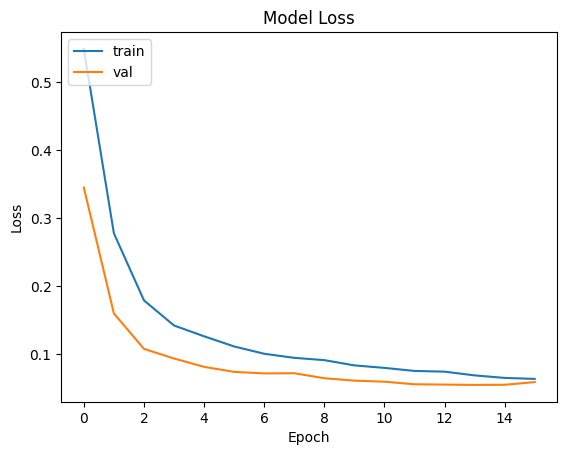

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()

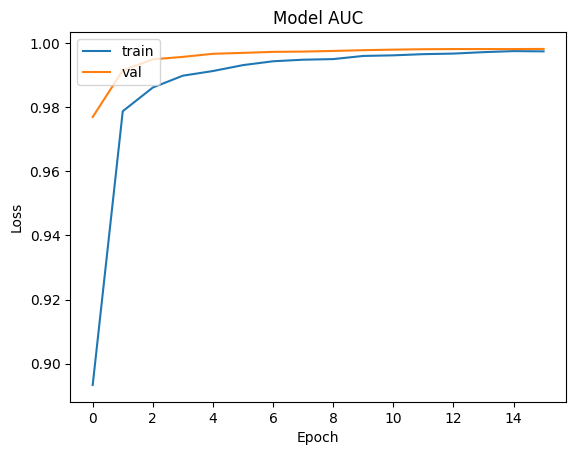

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()

### Evaluate performance on the test set

In [ ]:
y = np.concatenate([y for _, y in test_ds], axis=0)
prediction = model.predict(test_ds)

print(roc_auc_score(y, prediction))

82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step
0.992833928853624


### Plotting ROC Curve

In [ ]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots()
display = RocCurveDisplay.from_predictions(
    y,
    prediction,
    ax=ax
)

_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curve:",
)

### Save the entire model as an alternative option

In [ ]:
model.save('/content/drive/MyDrive/DeepLenseGSOC/Task2/task_2_model.keras')